### Import and settings

In [159]:
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib inline
# import snscrape.modules.twitter as sntwitter
import pandas as pd
import tqdm
import yaml
#
import json
import time
import datetime
import tqdm 
import os
# from datetime import datetime, timezone, timedelta
import re
from twarc.client2 import Twarc2
from twarc.expansions import ensure_flattened, flatten
import numpy as np
import re

In [160]:
# Paramètres cosmétiques
# Taille des graphiques
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rc_file_defaults()
plt.rcParams["figure.figsize"] = [15, 10]
# Taille de l'affichage des données pandas
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)

In [161]:
with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
token = config['bearer_token']

### Building Query

Original queries (MOBILISE Belarus hashtags)

In [162]:
queries = ["(#Minska OR #LukashenkoOut OR #BelarusStrong OR #LukashenkoLeaveNow OR #лукашенкоубийца OR #БеларусьРеволюція)",
"(#belarus OR #minsk OR #ЛукашенкоУходи OR #LukashenkoGoAway OR #BelarusProtest OR #BelarusProtests OR #FreeBelarus OR #zhyvebelarus OR #ЖывеБеларусь OR #prayforbelarus OR #helpbelarus OR #freebelarus OR #freedombelarus OR #savebelarus)" ,
"(#BelarusFreedom OR #Belarus2020 OR #Lukashenko OR #Belaruslivesmatter OR #BelarusSolidarity OR #FreedomforBelarus OR #ЖывэБеларусь OR #ЖивеБеларусь OR #Беларусь  OR #Беларусь2020  OR #LongLiveBelarus  OR #Уходи  OR #автозак)",
"(#лукашенковавтозак OR #ЖывеБелорусь OR #жыве_беларусь OR #лошкипетушки OR #Белoрусь OR #Минск OR #ЖивеБілорусь OR #MinskMaidan)",
"(#belaruselections OR #belaruselections2020 OR #LukashenkoLeave OR #Minskprotests OR #standwithbelarus OR #BelarusRevolution OR #BelarusWatch OR #belarusstrike OR #ЛукашескуТыСледующий)",
"(#ЛукашенкоДиктатор OR #лукашенкокровавыйдиктатор OR #лукашенкокровавыйубийца OR #ЛукашенкоДиктатор OR #Лукашеску OR #кровавыйтаракан OR #СтопТаракан OR #сашатрипроцента)",
"(#she4belarus OR #беларуски_против_диктатуры OR #беларускі_супраць_дыктатуры)"]

In [163]:
# /!\ Several queries will return overlapping matches (thus duplicates), use single string query if possible
# List of hashtags is too long (API max lenght for request = 1024 chars)
single_q = "(#Minska OR #LukashenkoOut OR #BelarusStrong OR #LukashenkoLeaveNow OR #лукашенкоубийца OR #БеларусьРеволюція OR #belarus OR #minsk OR #ЛукашенкоУходи OR #LukashenkoGoAway OR #BelarusProtest OR #BelarusProtests OR #FreeBelarus OR #zhyvebelarus OR #ЖывеБеларусь OR #prayforbelarus OR #helpbelarus OR #freebelarus OR #freedombelarus OR #savebelarus OR #BelarusFreedom OR #Belarus2020 OR #Lukashenko OR #Belaruslivesmatter OR #BelarusSolidarity OR #FreedomforBelarus OR #ЖывэБеларусь OR #ЖивеБеларусь OR #Беларусь OR #Беларусь2020 OR #LongLiveBelarus OR #Уходи OR #автозак OR #лукашенковавтозак OR #ЖывеБелорусь OR #жыве_беларусь OR #лошкипетушки OR #Белoрусь OR #Минск OR #ЖивеБілорусь OR #MinskMaidan OR #belaruselections OR #belaruselections2020 OR #LukashenkoLeave OR #Minskprotests OR #standwithbelarus OR #BelarusRevolution OR #BelarusWatch OR #belarusstrike OR #ЛукашескуТыСледующий OR #ЛукашенкоДиктатор OR #лукашенкокровавыйдиктатор OR #лукашенкокровавыйубийца OR #ЛукашенкоДиктатор OR #Лукашеску OR #кровавыйтаракан OR #СтопТаракан OR #сашатрипроцента)"
# Drop the N least frequent hashtags (< 50 tweets) to shorten the string
for h in ['#Белoрусь', '#сашатрипроцента', '#лукашенковавтозак', '#автозак', '#лошкипетушки', '#кровавыйтаракан', '#ЛукашенкоДиктатор'][:5] :
       single_q=single_q.replace(' OR '+h, '')
print('length :' + str(len(single_q)), single_q)

length :975 (#Minska OR #LukashenkoOut OR #BelarusStrong OR #LukashenkoLeaveNow OR #лукашенкоубийца OR #БеларусьРеволюція OR #belarus OR #minsk OR #ЛукашенкоУходи OR #LukashenkoGoAway OR #BelarusProtest OR #BelarusProtests OR #FreeBelarus OR #zhyvebelarus OR #ЖывеБеларусь OR #prayforbelarus OR #helpbelarus OR #freebelarus OR #freedombelarus OR #savebelarus OR #BelarusFreedom OR #Belarus2020 OR #Lukashenko OR #Belaruslivesmatter OR #BelarusSolidarity OR #FreedomforBelarus OR #ЖывэБеларусь OR #ЖивеБеларусь OR #Беларусь OR #Беларусь2020 OR #LongLiveBelarus OR #Уходи OR #ЖывеБелорусь OR #жыве_беларусь OR #Минск OR #ЖивеБілорусь OR #MinskMaidan OR #belaruselections OR #belaruselections2020 OR #LukashenkoLeave OR #Minskprotests OR #standwithbelarus OR #BelarusRevolution OR #BelarusWatch OR #belarusstrike OR #ЛукашескуТыСледующий OR #ЛукашенкоДиктатор OR #лукашенкокровавыйдиктатор OR #лукашенкокровавыйубийца OR #ЛукашенкоДиктатор OR #Лукашеску OR #кровавыйтаракан OR #СтопТаракан)


In [164]:
' OR '.join(['#Белoрусь', '#сашатрипроцента', '#лукашенковавтозак', '#автозак', '#лошкипетушки', '#кровавыйтаракан', '#ЛукашенкоДиктатор'])

'#Белoрусь OR #сашатрипроцента OR #лукашенковавтозак OR #автозак OR #лошкипетушки OR #кровавыйтаракан OR #ЛукашенкоДиктатор'

In [165]:
# Extracting hashtags from request list
hashtags = re.findall(r'#\S+', ' '.join([q[:-1]for q in queries]))
print(hashtags)

['#Minska', '#LukashenkoOut', '#BelarusStrong', '#LukashenkoLeaveNow', '#лукашенкоубийца', '#БеларусьРеволюція', '#belarus', '#minsk', '#ЛукашенкоУходи', '#LukashenkoGoAway', '#BelarusProtest', '#BelarusProtests', '#FreeBelarus', '#zhyvebelarus', '#ЖывеБеларусь', '#prayforbelarus', '#helpbelarus', '#freebelarus', '#freedombelarus', '#savebelarus', '#BelarusFreedom', '#Belarus2020', '#Lukashenko', '#Belaruslivesmatter', '#BelarusSolidarity', '#FreedomforBelarus', '#ЖывэБеларусь', '#ЖивеБеларусь', '#Беларусь', '#Беларусь2020', '#LongLiveBelarus', '#Уходи', '#автозак', '#лукашенковавтозак', '#ЖывеБелорусь', '#жыве_беларусь', '#лошкипетушки', '#Белoрусь', '#Минск', '#ЖивеБілорусь', '#MinskMaidan', '#belaruselections', '#belaruselections2020', '#LukashenkoLeave', '#Minskprotests', '#standwithbelarus', '#BelarusRevolution', '#BelarusWatch', '#belarusstrike', '#ЛукашескуТыСледующий', '#ЛукашенкоДиктатор', '#лукашенкокровавыйдиктатор', '#лукашенкокровавыйубийца', '#ЛукашенкоДиктатор', '#Лукаше

Query for languages

In [166]:
langstr=['lang:en',
'lang:ru',
'lang:de',
'lang:th',
'lang:und',
'lang:fr',
'lang:pl',
'lang:it',
'lang:es',
'lang:tr']
lang_queries = [single_q+' '+s for s in langstr]

In [167]:
geoquer='has:geo '+single_q

Hashtags to exclude  
*note : those are hashtags we exclude ~from the list of new hashtags we'll download~*

In [169]:
from new_hashtags_list import exclude_hashtags

In [170]:
# Remove duplicates
print(len(exclude_hashtags))
exclude_hashtags=list(dict.fromkeys(exclude_hashtags))
print(len(exclude_hashtags))
print(exclude_hashtags)

103
81
['เสาหลักจะหักเผด็จการ', 'russia', 'politics', 'poland', 'putin', 'eu', 'europe', 'standwithhongkong', 'hongkong', 'milkteaalliance', 'fridaysforfreedom', 'thailand', 'china', 'breaking', 'navalny', 'nato', 'standwiththailand', 'covid19', 'freehongkong', 'instagram', 'venezuela', 'humanrights', '2020election', 'policebrutality', 'fightforfreedom', 'protests', 'protest', 'peoplepower', 'lithuania', 'thepeople', 'standwithhk', 'bewater', 'femxarxa', 'putinspuppet', 'armenia', 'killedbypolice', 'stopdictator', 'навальный', 'coronavirusfemxarxa', 'коронавирус', 'hkerswithyouhongkongers', 'save12hkyouths', 'milkteaalliancefreehongkong', 'hk2belarus', 'hk', 'hong kong', 'hong-kong', 'trumpsamerica', 'azerbaijan', 'beirut', 'uyghurs', 'ultimahora', 'standwithuyghurs', 'somoscontinuidad', 'крымукраина', 'путинубийца', 'caracas', 'maracaibo', 'tel-aviv', 'sanfrancisco', 'мнепятнадцать', 'юмор', 'cryptocurrency', 'crypto', 'contest', 'bitcoin', 'ETH', 'blockchain', 'BTC', 'FIAT', 'virtual

In [171]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from new_hashtags import new_h
q_supp_1 = ['#'+h+' -'+single_q for h in new_h if h not in exclude_hashtags]
# Remove duplicates
q_supp_1 = list(dict.fromkeys(q_supp_1))
len(q_supp_1)
print(['#'+h for h in new_h if h not in exclude_hashtags])

['#lukaschenko', '#tsikhanouskaya', '#bélarus', '#bielorussia', '#bielorrusia', '#belaruspresidentialelection', '#lukashenka', '#tikhanovskaya', '#belarusian', '#bielorussie', '#лукашенко', '#brest', '#belaruselection', '#solidaritywithbelarus', '#protestsinbelarus', '#bahinskaya', '#belarusians', '#białoruś', '#loukachenko', '#hrodna', '#belarús', '#tichanowskaja', '#grodno', '#biélorussie', '#kalesnikava', '#highlightbelarus', '#belarusinaction', '#bialorus', '#mińsk', '#belaruselection', '#лукашенко', '#kolesnikova', '#romanbondarenko', '#белоруссия', '#strikebelarus', '#okrestina', '#belsat', '#baltkrievija', '#mariakolesnikova', '#weißrussland', '#kolesnikowa', '#svetlanatikhanovskaya', '#тихановская', '#omon', '#ninabaginskaya', '#supportbelarus', '#women_in_white', '#weissrussland', '#wolnabiałoruś', '#alexanderlukashenko', '#хабаровск', '#homiel', '#bandarenka', '#alexievich', '#тихоновоская', '#минске', '#białoruś', '#kyiv', '#salihorsk', '#womenrisingfordemocracy', '#orlovska

Top hashtags (cyrillic)

In [172]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from new_hashtags import h_cyrillic, new_h
# These hashtags showed up, but we will not look them up (too generic or irrelevant)
exclude_c_hashtags=['гулаг', 'украина', 'хабаровск', 'новости', 'россия',  "україна", "сша", "история", "путин", 
'навальный', 'президент', 'невзоров', "политика", 'революция', 'война', 'россияпроснись', 'перемен', 'оппозиция', "лавров", 'социалистических', "установлен"
 'советских', 'республик', 'союз', 'донбасс', 'русский', 'победа', 'польша', 'фашизм', "победа75", 'москва', 'митинги', 'милиция','барбарико', 'русские', 'видео', 'митинг', 'крым',
 'правачеловека', 'китай', 'засвободу', 'мид', 'автомат', 'свобода', 'жыве', 'пропаганда', 'пагоняпобач', "народ", 'казахстан', 'диктатура', 'общество', 'кгб', 'гестапо', 'новость',
 '60минут', 'запобеду', 'майдан', 'літва', 'бнр', 'сми', 'кремль', 'коротченко', 'польшча', 'говнодед', 'майдан', 'санкции', 'москва', 'навальныйживи', 'ес', 'вкл', 'экономика', 'трипроцента'
 'искусство', 'дипломатия', 'коронавирус', 'акции', 'распродажи', 'скидки', 'или', 'полицияубивает',
 'протест' # Include 'protest" ? trop générique ?
 ]
h_cyrillic = [h for h in h_cyrillic if h not in exclude_c_hashtags and h not in new_h]
# Remove duplicates from list
h_cyrillic = list( dict.fromkeys(h_cyrillic) )
print('Top 100 hashtags, cyrillic : ') 
print(h_cyrillic)
len(h_cyrillic)

Top 100 hashtags, cyrillic : 
['живэбеларусь', 'живебелорусь', 'протесты', 'омон', 'жывэбелорусь', 'выборы2020', 'беларуси', 'противлукашенко', 'беларусьмысвами', 'живэбелорусь', 'мглу', 'сябрысила', 'каратель', 'установлен', 'лукашэнка', 'свободнаябеларусь', 'жывeбеларусь', 'брест', 'выборыбелоруссия', 'выборыбеларусь2020', 'светланатихановская', 'протестыбеларусь', 'бчб', 'они_давили_народ', 'длятрибунала', 'новополоцк', 'протестыбелоруссия', 'верымможампераможам', 'беларус', 'мінск', 'цепкало', 'минска', 'чтобыпомнили', 'ягуляю', 'явыхожу', 'вясна', 'беларусьвыборы', 'беларусі', 'вов', 'мвд', 'оон', 'гродно', 'ямы97', 'беларусов', 'менск', 'забастовка', 'михнович_кирилл', 'странадляжизни', 'нехта', 'полоцк', 'новости_беларуси', 'рб', 'гомель', 'выбары2020', 'таракануходи', 'шишмаков', 'ціханоўская', 'змагары', 'верамможампераможам', 'свободасобраний', 'витебск', 'живибеларусь', 'бнф', 'произвол', 'пытки', 'ямыбатька', 'мінськ', 'белоруссии', 'игорькоротченко', 'змагар', 'белорусь', 

93

In [173]:
q_supp_2 = ['#'+h+' -'+single_q for h in h_cyrillic]
len(q_supp_2)

93

Trending hashtags (from web crawlers)
* https://archive.twitter-trending.com/belarus/20-08-2020
* https://www.exportdata.io/trends/belarus/2020-08-11/23
* 

In [174]:
h_trending = ['psiphon', 'Корж', 'Коржа', 'Жодино', 
# 'Возможно',  # écarté, trop d'occurrences
"#BelarusSolidarity", 	
"Belarusian",
'#выборы',  # limiter cette recherche à une plus courte période (10 au 20 août)
'молотова', # Idem
'СИЗО', # Idem
'МЗКТ', # Août seulement
'#FreeBelarus',
'#Belarus2020',
'Латушко',
'дзякуй',
'Окрестина',
'Окрестино',
"Реальный Брест",
"Пушкинской",
'#belarussolidarity',
'цепкало']

In [175]:
trends = [h+' -'+single_q for h in h_trending if h not in hashtags and re.sub('#', '', h.lower()) not in h_cyrillic and re.sub('#', '', h.lower()) not in new_h]
print ([(i, a[:20]) for i, a in enumerate(list( dict.fromkeys(trends) ))]) # removes duplicates

[(0, 'psiphon -(#Minska OR'), (1, 'Корж -(#Minska OR #L'), (2, 'Коржа -(#Minska OR #'), (3, 'Жодино -(#Minska OR '), (4, '#выборы -(#Minska OR'), (5, 'молотова -(#Minska O'), (6, 'СИЗО -(#Minska OR #L'), (7, 'МЗКТ -(#Minska OR #L'), (8, 'Латушко -(#Minska OR'), (9, 'дзякуй -(#Minska OR '), (10, 'Окрестина -(#Minska '), (11, 'Окрестино -(#Minska '), (12, 'Реальный Брест -(#Mi'), (13, 'Пушкинской -(#Minska'), (14, '#belarussolidarity -')]


In [176]:
to_run =[single_q,
q_supp_1,
q_supp_2,
trends]

In [177]:
single_q_1_1= '('+' OR '.join(['#'+h for h in new_h[:-25] if h not in exclude_hashtags])+')'
single_q_1_2= '('+' OR '.join(['#'+h for h in new_h[-25:] if h not in exclude_hashtags])+')'
single_q_2_1= '('+' OR '.join(['#'+h for h in h_cyrillic[:-25]])+')'
single_q_2_2= '('+' OR '.join(['#'+h for h in h_cyrillic[-25:]])+')'
single_q_trending= '('+ ' OR '.join([h for h in h_trending])+ ')'
allq= [single_q,
[single_q_1_1,
single_q_1_2],
[single_q_2_1,
single_q_2_2],
single_q_trending] 
for i in allq:
    print (str(len(i)))
    print (i)

975
(#Minska OR #LukashenkoOut OR #BelarusStrong OR #LukashenkoLeaveNow OR #лукашенкоубийца OR #БеларусьРеволюція OR #belarus OR #minsk OR #ЛукашенкоУходи OR #LukashenkoGoAway OR #BelarusProtest OR #BelarusProtests OR #FreeBelarus OR #zhyvebelarus OR #ЖывеБеларусь OR #prayforbelarus OR #helpbelarus OR #freebelarus OR #freedombelarus OR #savebelarus OR #BelarusFreedom OR #Belarus2020 OR #Lukashenko OR #Belaruslivesmatter OR #BelarusSolidarity OR #FreedomforBelarus OR #ЖывэБеларусь OR #ЖивеБеларусь OR #Беларусь OR #Беларусь2020 OR #LongLiveBelarus OR #Уходи OR #ЖывеБелорусь OR #жыве_беларусь OR #Минск OR #ЖивеБілорусь OR #MinskMaidan OR #belaruselections OR #belaruselections2020 OR #LukashenkoLeave OR #Minskprotests OR #standwithbelarus OR #BelarusRevolution OR #BelarusWatch OR #belarusstrike OR #ЛукашескуТыСледующий OR #ЛукашенкоДиктатор OR #лукашенкокровавыйдиктатор OR #лукашенкокровавыйубийца OR #ЛукашенкоДиктатор OR #Лукашеску OR #кровавыйтаракан OR #СтопТаракан)
2
['(#lukaschenko OR

### Count request

In [187]:
# Setup start and end time with proper format
start_time = datetime.datetime(2020, 6, 1, 0, 0, 0, 0, datetime.timezone.utc)
end_time = datetime.datetime(2020, 8, 8, 0, 0, 0, 0, datetime.timezone.utc)

In [211]:
from urllib.error import HTTPError
t = Twarc2(bearer_token=token)

df_counts=pd.DataFrame()
for q,query in enumerate(rqs) :
    try :
        search_results = t.counts_all(query=query, start_time=start_time, end_time=end_time,
                                    # # Specify expansions as needed ( = objects to collect, such as User)
                                    # max_results=
                                    granularity='day'
                                    )
        df_query=pd.DataFrame()
        print(f"Counting tweets for query " +str(q+1)+ f": \"{query[:30]}...\" from {start_time} to {end_time}...")
        for page in search_results:
            df_page=pd.DataFrame(page['data']).set_index('start')
            df_query=pd.concat([df_query, df_page])

        print ('Total '+query[:50]+'... : '+str(sum(df_query['tweet_count'])))

        # # Name for resulting columns : query 1, query 2... or #Minsk
        # df_counts = pd.concat([df_counts, df_query['tweet_count'].rename('query'+str(q+1)+'_count')], axis=1)
        df_counts = pd.concat([df_counts, df_query['tweet_count'].rename(query[:30])], axis=1)
    except HTTPError :
        continue

    # # Limit number of queries
    # if q==0 :
    #     break


Counting tweets for query 1: "(#election2020 (place_country:..." from 2020-06-01 00:00:00+00:00 to 2020-08-08 00:00:00+00:00...
Total (#election2020 (place_country:BY OR place_country:... : 2
Counting tweets for query 2: "Белгазпромбанк - ((#election20..." from 2020-06-01 00:00:00+00:00 to 2020-08-08 00:00:00+00:00...
Total Белгазпромбанк - ((#election2020 (place_country:BY... : 570
Counting tweets for query 3: "Беларусі - ((#election2020 (pl..." from 2020-06-01 00:00:00+00:00 to 2020-08-08 00:00:00+00:00...
Total Беларусі - ((#election2020 (place_country:BY OR pl... : 7995
Counting tweets for query 4: "свободутихановскому - ((#elect..." from 2020-06-01 00:00:00+00:00 to 2020-08-08 00:00:00+00:00...
Total свободутихановскому - ((#election2020 (place_count... : 260
Counting tweets for query 5: "(#election2020 belarus) - ((#e..." from 2020-06-01 00:00:00+00:00 to 2020-08-08 00:00:00+00:00...
Total (#election2020 belarus) - ((#election2020 (place_c... : 612
Counting tweets for query 6: "б

### Parsing results

In [ ]:
# If we want to load previous results
# df_counts=pd.read_csv('all_h_0105_0908.csv')


In [194]:
# Setting index as datetime
df_counts=df_counts.set_index(pd.DatetimeIndex(df_counts.index)).sort_index(ascending=True)

In [195]:
# Rename single column if necessary
df_counts.rename(columns={df_counts.columns[0]:'tweet_count'}, inplace=True)
# Rename Multiple columns if necessary
# df_counts.rename(columns=dict(zip(df_counts.columns, langstr)), inplace=True)

In [119]:
# Export results to csv
df_counts.to_csv('all_h_0105_0908.csv')

Quick viz single count

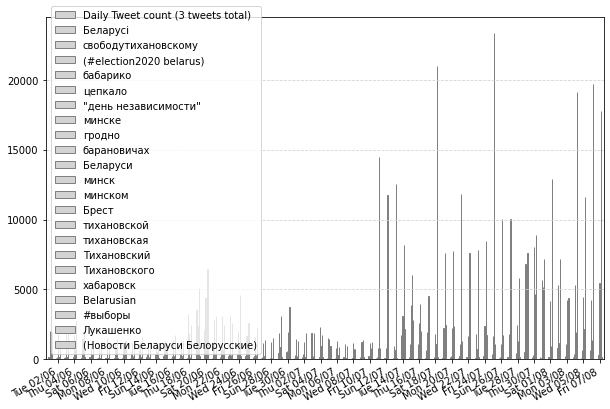

In [197]:
# Quick visualize single barplot
import matplotlib.dates as mdates 
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
fig, ax =plt.subplots()
plotted=df_counts.loc[(df_counts.index>='2020-06-01') & (df_counts.index<='2020-08-07')]
plotted.index=plotted.index.strftime('%a %d/%m')
plotted=plotted.rename(columns={'tweet_count' : 'Daily Tweet count (%d tweets total)'%(plotted.tweet_count.sum())})
plotted.plot(ax=ax, kind='bar', color='lightgray', width=0.5, edgecolor='gray', figsize=(10,7))
# df_counts.plot(ax=ax, kind='bar', color='lightgray', width=0.5, edgecolor='gray', figsize=(20,8))
plt.legend(str(plotted.tweet_count.sum()))
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
fig.autofmt_xdate()
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(1), interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=2))
plt.show();

Quick viz multiple counts

In [120]:
df_counts = df_counts.loc[:,~df_counts.columns.duplicated(keep='first')]
df_counts.sum().sort_values(ascending=False)

(#Minska OR #LukashenkoOut OR #BelarusStrong OR #L    208114
СИЗО -(#Minska OR #LukashenkoOut OR #BelarusStrong     46120
#хабаровск -(#Minska OR #LukashenkoOut OR #Belarus     35011
#brest -(#Minska OR #LukashenkoOut OR #BelarusStro     24481
молотова -(#Minska OR #LukashenkoOut OR #BelarusSt     21294
Пушкинской -(#Minska OR #LukashenkoOut OR #Belarus     14663
#вов -(#Minska OR #LukashenkoOut OR #BelarusStrong     12241
#kyiv -(#Minska OR #LukashenkoOut OR #BelarusStron     10128
#bialorus -(#Minska OR #LukashenkoOut OR #BelarusS      7599
#białoruś -(#Minska OR #LukashenkoOut OR #BelarusS      7598
#лукашенко -(#Minska OR #LukashenkoOut OR #Belarus      6718
#оон -(#Minska OR #LukashenkoOut OR #BelarusStrong      6425
#мвд -(#Minska OR #LukashenkoOut OR #BelarusStrong      5815
psiphon -(#Minska OR #LukashenkoOut OR #BelarusStr      5060
#выборы -(#Minska OR #LukashenkoOut OR #BelarusStr      4569
Коржа -(#Minska OR #LukashenkoOut OR #BelarusStron      4521
дзякуй -(#Minska OR #Luk

Total collected  : 845924


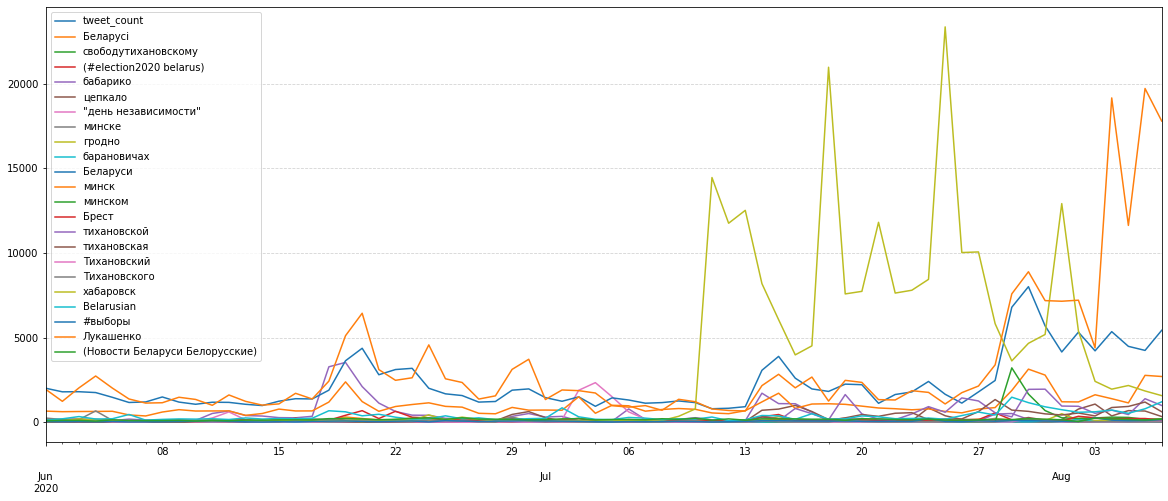

In [198]:
# df_counts = pd.read_csv('all_h_july.csv', index_col=0)
# Setting index as datetime
df_counts=df_counts.set_index(pd.DatetimeIndex(df_counts.index)).sort_index(ascending=True)
print('Total collected  : '+str(df_counts.sum().sum()))
# Splitting many columns
n = len(df_counts.columns)
# using list comprehension
colsets = [df_counts.columns[i * n:(i + 1) * n] for i in range((len(df_counts.columns) + n - 1) // n )]
for cols in colsets[:3] :
    fig, ax =plt.subplots()
    df_counts[cols].loc[(df_counts[cols].index>='2020-05-01') & (df_counts[cols].index<='2020-08-09')].plot(ax=ax, figsize=(20,8))
    # df_counts.loc[(df_counts.index>='2020-08-07')]['молотова -(#Minska OR #LukashenkoOut OR #BelarusSt'].plot(ax=ax, figsize=(20,8))
    plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
    # fig.autofmt_xdate()


### Analysis of counts for cyrillic hashtags

In [ ]:
# Collected hashtags (Cyrillic)
['живэбеларусь', 'живебелорусь', 'протесты', 'омон', 'жывэбелорусь', 'выборы2020', 'беларуси',
'противлукашенко', 'беларусьмысвами', 'живэбелорусь', 'мглу', 'сябрысила', 'каратель', 'установлен', 'лукашэнка',
'свободнаябеларусь', 'жывeбеларусь', 'брест', 'выборыбелоруссия', 'выборыбеларусь2020', 'светланатихановская',
'протестыбеларусь', 'бчб', 'они_давили_народ', 'длятрибунала', 'новополоцк', 'протестыбелоруссия', 'верымможампераможам',
'беларус', 'мінск', 'цепкало', 'минска', 'чтобыпомнили', 'ягуляю', 'явыхожу', 'вясна', 'беларусьвыборы', 'беларусі', 'вов',
'мвд', 'оон', 'гродно', 'ямы97', 'беларусов', 'менск', 'забастовка', 'михнович_кирилл', 'странадляжизни', 'нехта', 'полоцк',
'новости_беларуси', 'рб', 'гомель', 'выбары2020', 'таракануходи', 'шишмаков', 'ціханоўская', 'змагары', 'верамможампераможам',
'свободасобраний', 'витебск', 'живибеларусь', 'бнф', 'произвол', 'пытки', 'ямыбатька', 'мінськ', 'белоруссии', 'игорькоротченко',
'змагар', 'белорусь', 'плошча', 'колесникова', 'белаз', 'литва', 'россияпротивлукашенко', 'могилев', 'язалукашенко',
'протестывбеларуси', 'беларуссия', 'лукошенкоуходи', 'борисьбеларусь', 'божахранібеларусь', 'бабарико', 'беларусьживи', 'свободумарииколесниковой',
'білоруськіпротести', 'кобрин', 'уняволі', 'екрп', 'беларуских', 'безправанарасправу', 'куштауживи']

Total collected : 144750


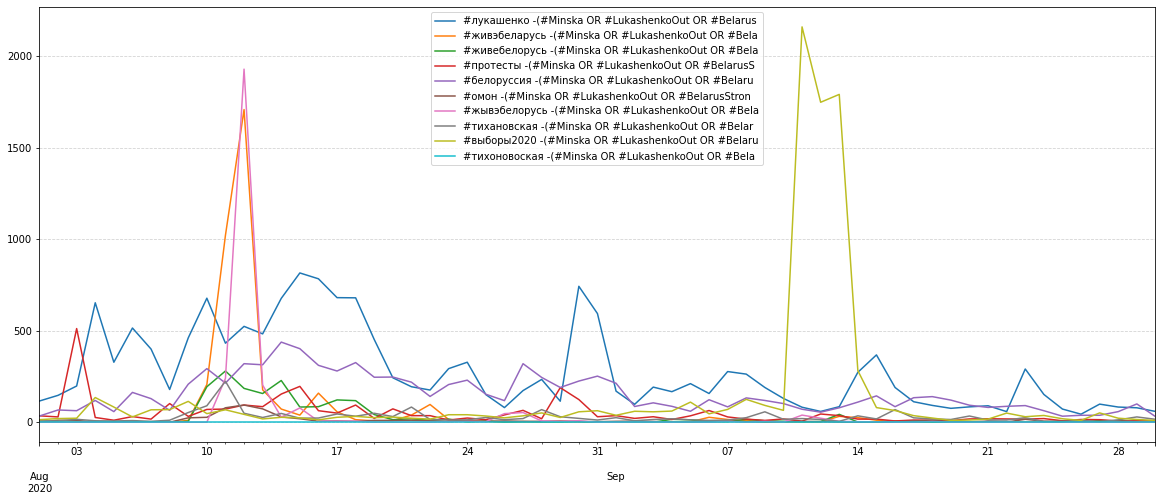

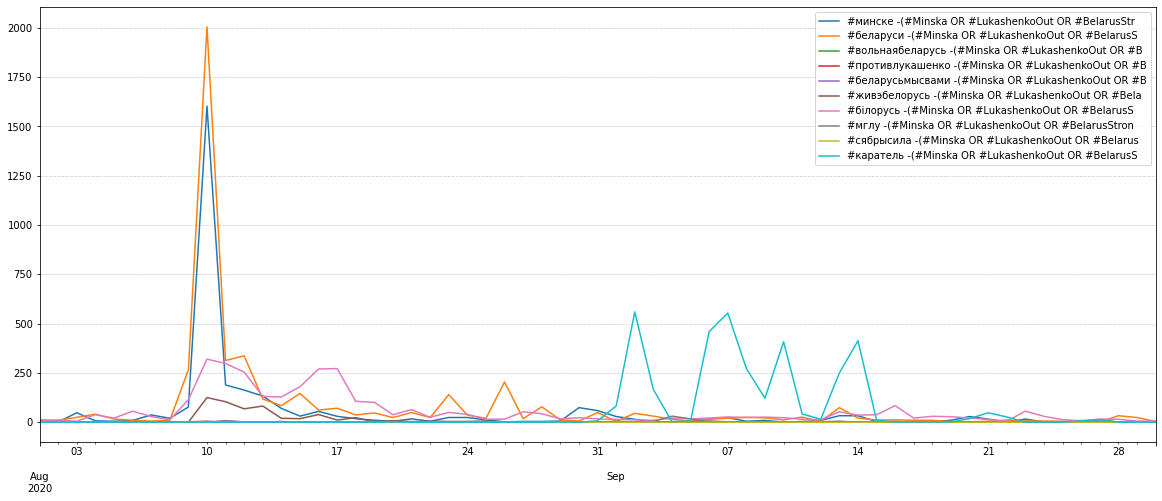

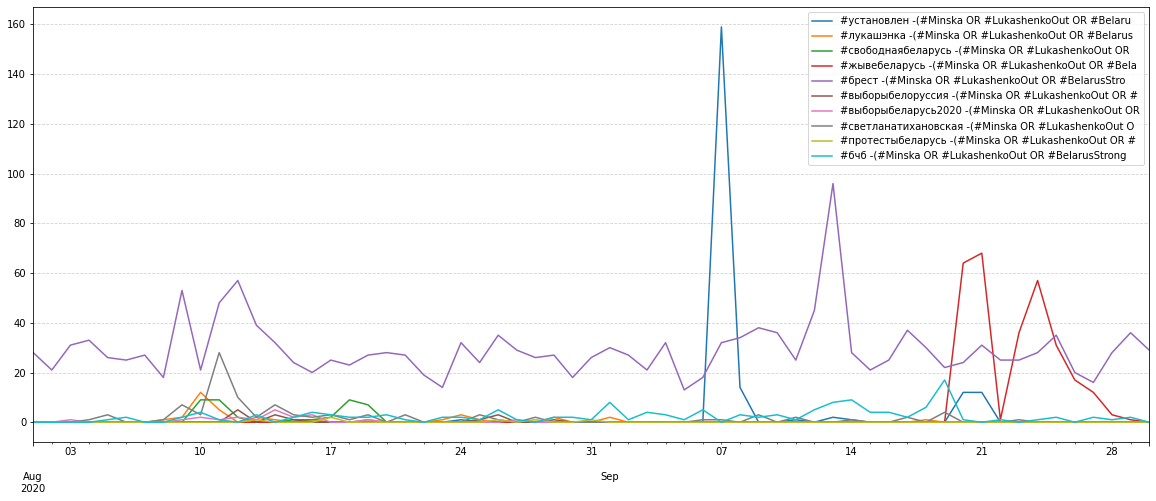

In [39]:
count_cyr = pd.read_csv('count_h_cyrillic_100.csv', index_col=0)
# Setting index as datetime
count_cyr=count_cyr.set_index(pd.DatetimeIndex(count_cyr.index)).sort_index(ascending=True)
print('Total collected (aug-dec) : '+str(count_cyr.sum().sum()))
print('Total collected (nov-dec) : '+str(count_cyr.sum().sum()))
# Splitting many columns
n = 10
# using list comprehension
colsets = [count_cyr.columns[i * n:(i + 1) * n] for i in range((len(count_cyr.columns) + n - 1) // n )]
for cols in colsets[:3] :
    fig, ax =plt.subplots()
    count_cyr[cols].loc[(count_cyr[cols].index>='2020-08-01') & (count_cyr[cols].index<='2020-09-30')].plot(ax=ax, figsize=(20,8))
    # df_counts.loc[(df_counts.index>='2020-08-07')]['молотова -(#Minska OR #LukashenkoOut OR #BelarusSt'].plot(ax=ax, figsize=(20,8))
    plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
    # fig.autofmt_xdate()


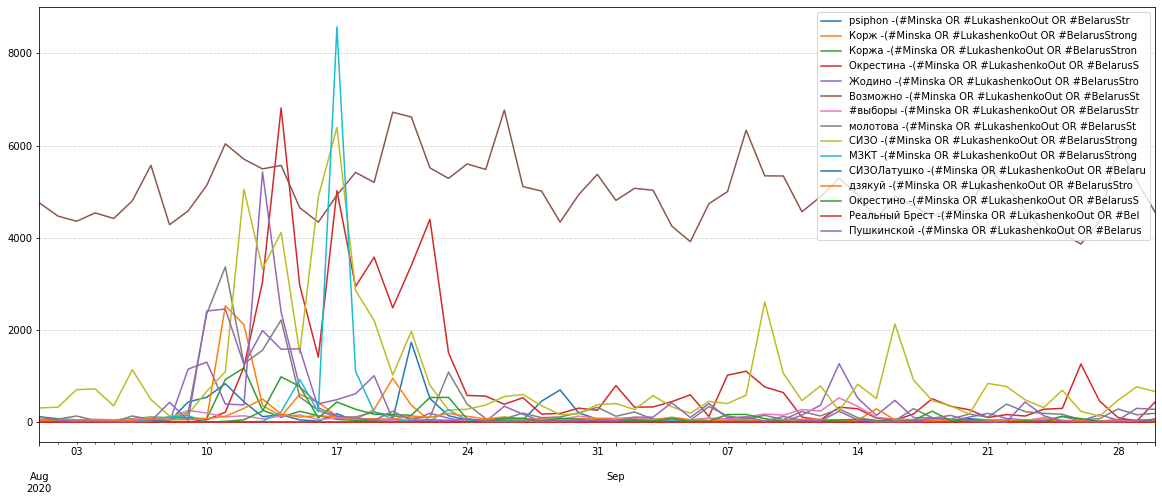

In [46]:
fig, ax =plt.subplots()
df_counts.loc[(df_counts.index>='2020-08-01') & (df_counts.index<='2020-09-30')].plot(ax=ax, figsize=(20,8))
# df_counts.loc[(df_counts.index>='2020-08-07')]['молотова -(#Minska OR #LukashenkoOut OR #BelarusSt'].plot(ax=ax, figsize=(20,8))
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# fig.autofmt_xdate()

Display count sum

In [127]:
df_counts.sum().sort_values(ascending=False) 

#armenia -(#Minska OR #LukashenkoOut OR #BelarusSt    2492263
#whatshappenninginthailand -(#Minska OR #Lukashenk     796096
#strajkkobiet -(#Minska OR #LukashenkoOut OR #Bela     447091
#hongkongers -(#Minska OR #LukashenkoOut OR #Belar     412876
#putinspuppet -(#Minska OR #LukashenkoOut OR #Bela     278622
#standwithhk -(#Minska OR #LukashenkoOut OR #Belar     191112
#policebrutalitymustend -(#Minska OR #LukashenkoOu     136254
#femxarxa -(#Minska OR #LukashenkoOut OR #BelarusS      90163
#bielorrusia -(#Minska OR #LukashenkoOut OR #Belar      55885
#bialorus -(#Minska OR #LukashenkoOut OR #BelarusS      50914
#białoruś -(#Minska OR #LukashenkoOut OR #BelarusS      50912
#brest -(#Minska OR #LukashenkoOut OR #BelarusStro      42456
#bielorussia -(#Minska OR #LukashenkoOut OR #Belar      36876
#bielorussie -(#Minska OR #LukashenkoOut OR #Belar      35726
#biélorussie -(#Minska OR #LukashenkoOut OR #Belar      35724
#хабаровск -(#Minska OR #LukashenkoOut OR #Belarus      22419
#лукашен

Hahstag counts

In [141]:
df = pd.read_csv('count_hashtags.csv', index_col=0)
df=df.set_index(pd.DatetimeIndex(df.index)).sort_index(ascending=True)
df.sum().sort_values(ascending=False)

#belarus                        1831115
#standwithbelarus                506607
#minsk                           498386
#Lukashenko                      234331
#ЖывеБеларусь                    184787
#BelarusProtest                  170867
#FreeBelarus                     152529
#freebelarus                     152509
#Беларусь                        113803
#BelarusProtests                  75299
#Belarus2020                      72089
#BelarusFreedom                   60205
#ЛукашенкоУходи                   49402
#LukashenkoGoAway                 45863
#BelarusSolidarity                42746
#Минск                            36329
#ЖивеБеларусь                     32261
#лукашенкоубийца                  16739
#LukashenkoOut                    14175
#LukashenkoLeaveNow                9723
#ЖывеБелорусь                      7527
#belaruselections2020              6412
#BelarusRevolution                 5599
#BelarusStrong                     4794
#belaruselections                  4238


### Lang analysis

<AxesSubplot:>

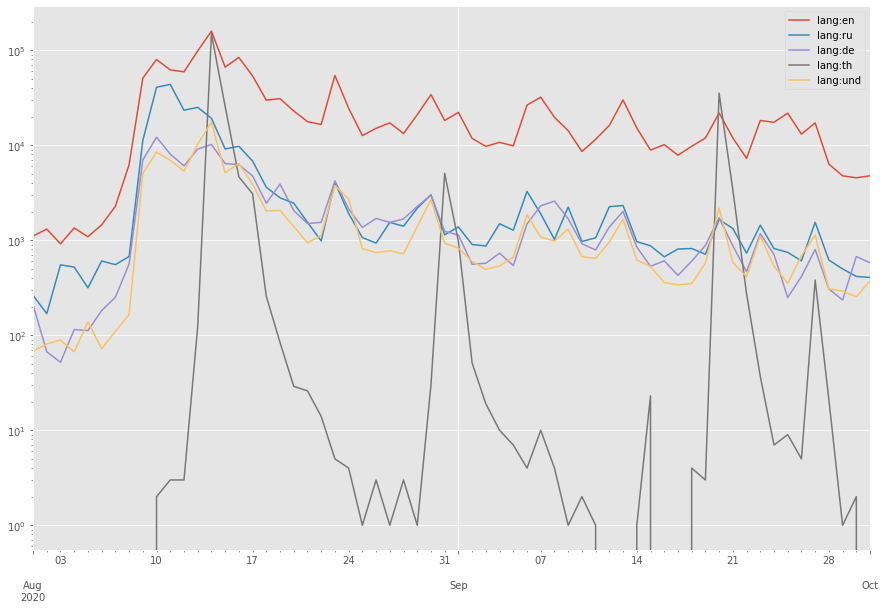

In [36]:
df_counts=pd.read_csv('count_langs.csv', index_col=0)
df_counts=df_counts.set_index(pd.DatetimeIndex(df_counts.index)).sort_index(ascending=True)
df_counts.iloc[:,:5]['2020-08-01':'2020-10-01'].plot(logy=True)

In [33]:
df_counts.to_csv('counts_v2.csv', index_label=False)

Plot of main languages count

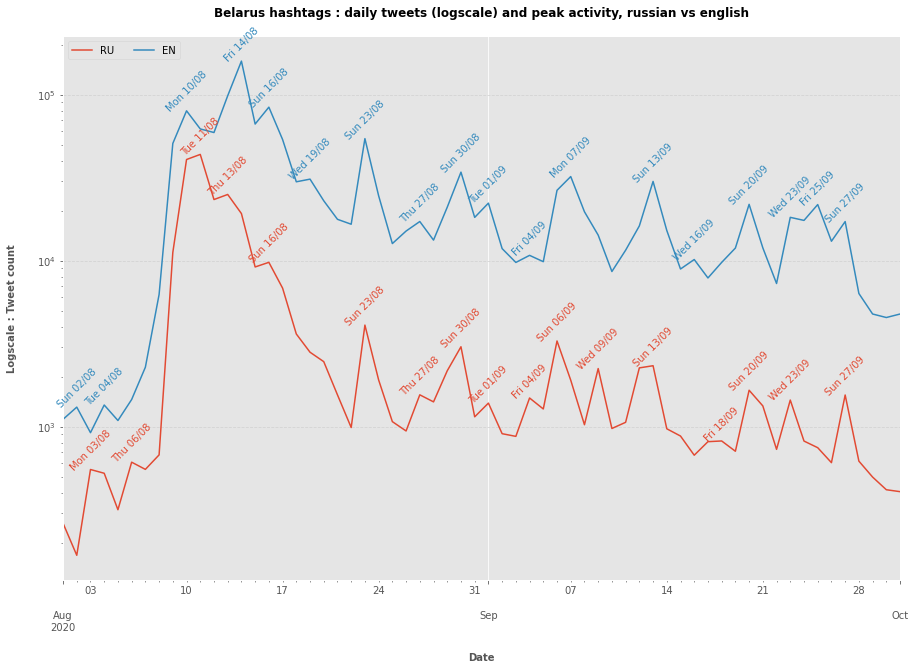

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
plt.title('Belarus hashtags : daily tweets (logscale) and peak activity, russian vs english', weight='bold', size=12, pad=20)
plt.grid(visible=1, axis='y', color='lightgray', linestyle='--')
# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=10)
# Set y-axis label
ax.set_ylabel("Logscale : Tweet count", labelpad=20, weight='bold', size=10)
# Compute and annotate peaks
from scipy.signal import find_peaks
for c in df_counts.columns :
    df_counts['2020-08-01':'2020-10-01'][c].plot(ax=ax, logy=True)
    peaks,dict = find_peaks(df_counts[c])
    for p in peaks :
        ax.annotate((df_counts.index[p].strftime('%a %d/%m')), (df_counts.index[p],df_counts[c].iloc[p]), color=plt.gca().lines[-1].get_color(), rotation=45, horizontalalignment='center')
    # ax.set_xticklabels(df_counts.iloc[peaks].index.values.dt.date)
        # ax.axvline(df_counts.index[p], linewidth=0.2, linestyle='-', color=plt.gca().lines[-1].get_color())
# fig.autofmt_xdate()
plt.legend(['RU', 'EN'], ncol=2, loc='upper left');
plt.show()

Plot top hashtags

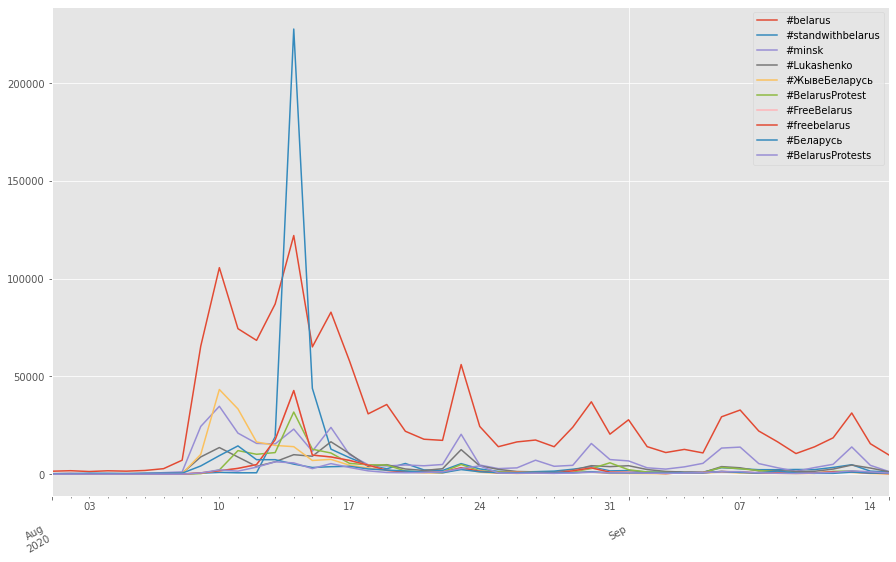

In [ ]:
# Plot des top hashtags
data_hashtags=pd.read_csv('count_hashtags.csv', index_col=0)
data_hashtags.index = pd.DatetimeIndex(data_hashtags.index)
s=data_hashtags.sum()
fig, ax = plt.subplots()
data_hashtags['2020-08-01':'2020-09-15'][s.sort_values(ascending=False).index[:10]].plot(ax=ax, logy=False)
fig.autofmt_xdate()